# Understanding LDS SVAE

## Setup

In [547]:
%load_ext autoreload
%autoreload 2

import torch

from vae import VAE
from svae.lds import SVAE
from svae.lds.local_optimization import local_optimization

from data import make_dot_data

from distributions import MatrixNormalInverseWishart
from distributions.gaussian import standard_pair_params, info_pair_params

from matrix_ops import unpack_dense, pack_dense

from run_lds import vae_parameters, data_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get model

In [548]:
# create the (encoder/decoder) network
network = VAE(**vae_parameters)

# create the LDS SVAE
model = SVAE(network, save_path=None)

# load trained model parameters for global parameters and the network
model.load_model(path="../trained_lds", epoch="trained")

### Get data

In [549]:
data_parameters = {
    "image_width": 12,
    "T": 500,
    "num_steps": 5000,
    "render_sigma": 0.20,
    "v": 0.75,
}

# make the synthetic data
observations = make_dot_data(**data_parameters)

# take a subset of the data
observations = observations[:200]

# convert data to tensor
data = torch.tensor(observations).to(model.vae.device).double()

### Forward pass

In [550]:
# get the encoded data
potentials = model.encode(data)

# set the potentials to zero after time step
scale, loc, _, _ = unpack_dense(potentials)
# loc[2:] = 0.0
# scale[2:] = 0.0
loc = torch.zeros_like(loc)
scale = torch.zeros_like(scale)

# transform the potentials back into convenient form
potentials = pack_dense(scale, loc)

In [551]:
from svae.lds.kalman import info_kalman_filter, info_sample_backward
from distributions import NormalInverseWishart
from distributions.gaussian import natural_to_info

# run message passing for LDS
# x, _, _ = local_optimization(potentials, eta_theta=model.eta_theta, n_samples=50)

y = list(zip(*natural_to_info(potentials)))

"""
priors
"""
niw_param, mniw_param = model.eta_theta

J11, J12, J22, logZ = MatrixNormalInverseWishart(mniw_param).expected_stats()
J11 = -2 * J11
J12 = -1 * J12
J22 = -2 * J22

# transform information parameters into standard parameters
A, Q = standard_pair_params(J11, J12, J22)
A -= torch.eye(len(A)) * 0.001
# A += .01
# Q *= 2

# transform standard parameters into information parameters
J11, J12, J22 = info_pair_params(A, Q)

local_natparam = NormalInverseWishart(niw_param).expected_stats()
init_param = natural_to_info(local_natparam), torch.sum(local_natparam[2:])

"""
optimize local parameters
"""
forward_messages, _ = info_kalman_filter(
    init_params=init_param, pair_params=(J11, J12, J22, logZ), observations=y
)
x = info_sample_backward(
    forward_messages, pair_params=(J11, J12, J22), n_samples=50
)
# x = x[1::2, :, :]
# x = torch.cat((x, x), 0)
# x.shape

In [552]:
# x = torch.clamp(x, min=-20, max=20)
# x[:, :, 9] += 100
# x *= 2

In [553]:
x.shape

torch.Size([200, 50, 10])

In [554]:
# get reconstruction
decoded_means, _ = model.decode(x.reshape(-1, x.shape[-1]))
decoded_means = decoded_means.reshape(*x.shape[:-1], -1)

# transpose
decoded_means = torch.swapaxes(decoded_means, axis0=0, axis1=1)
x = torch.swapaxes(x, axis0=0, axis1=1)

# Plotting

In [555]:
import matplotlib.pyplot as plt

from plot.lds_plot import (
    plot_latents,
    plot_potentials,
    plot_info_parameters,
    plot_global,
)

def plot_obs(obs, title=None, figsize=(10, 10)):
    """Plot the observations."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.matshow(obs.T, cmap="gray")
    # ax.axis("tight")
    # ax.axis("off")
    fig.suptitle(title)
    fig.tight_layout()
    return fig

seq_length = -1

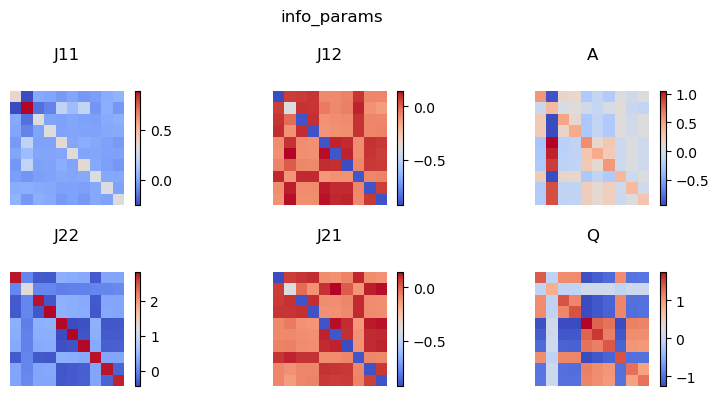

In [556]:
fig_info_params = plot_info_parameters(J11, J12, J22, J12.T, A, Q, title="info_params", figsize=(8, 4))

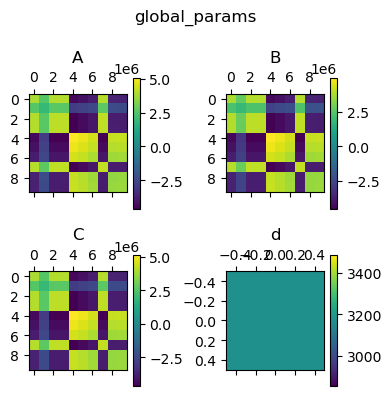

In [557]:
fig_global_params = plot_global(mniw_param, title="global_params", figsize=(4, 4))

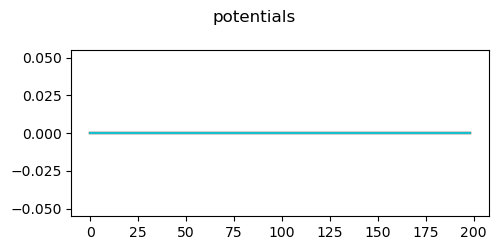

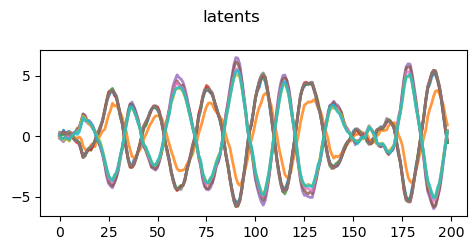

In [558]:
fig_potentials = plot_potentials(potentials, prefix=seq_length, title="potentials", figsize=(5, 2.5))

fig_latents = plot_latents(x.cpu().detach().numpy()[:, :seq_length], title="latents", figsize=(5, 2.5))

In [559]:
x[:, :seq_length].shape

torch.Size([50, 199, 10])

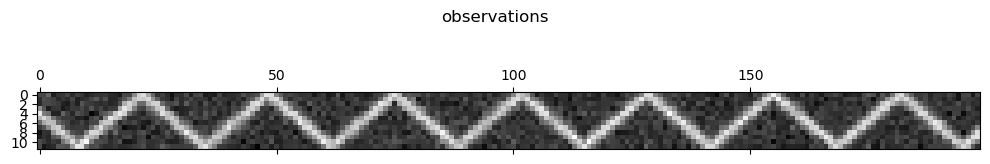

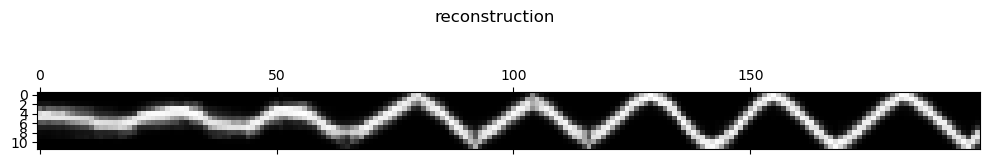

In [560]:
fig_obs = plot_obs(data.cpu().detach().numpy()[:seq_length], title="observations", figsize=(10, 2))

fig_samples = plot_obs(decoded_means[0].cpu().detach().numpy()[:seq_length], title="reconstruction", figsize=(10, 2))